## Overview
This notebook captures the implementation of various image augmentation techniques to improve the quality of the input data. Some of the things that we need to handle in this notebook includes
- Removal of duplicate data images from data 
- Handling of imbalanced classes
- Removal of certain crops that don't have an infected class
- Augmenting the data to improve the completeness of input data

### Setup Environment
Here are the commands that can be used to setup the environment required for executing this notebook. Make sure you have python version 3.9.0 or higher

In [2]:
# !pip install torch
# !pip install torchvision
# !pip install opencv-python
# !pip install matplotlib
# !pip install pandas
# !pip install scipy
# !pip install sklearn
# !pip install imgaug

In [38]:
# import the required packages 
import os
import math
import torch
import numpy
import pandas
import random
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt

import imgaug as ia
import imgaug.augmenters as iaa

import shutil
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.utils.data.sampler import BatchSampler

In [3]:
# define important variables
IMAGE_DIR = './images/train/'
PROCESSED_DIR = './images/processed/'
BALANCED_DIR = './images/balanced/'
INPUT_DIR = './images/input/train/'
FILE_TYPE = '.JPG'
BATCH_SIZE = 64
HASH_SIZE = 8
HIGHFREQ_FACTOR = 4

### Removal of Duplicate Images
The duplicate image input dictionary is obtained using perceptual hashing and hamming distance over the input images. This is implemented in "Image Classification EDA" notebook

In [4]:
# This input data is obtained from "Image Classification EDA" notebook
dup = [['./images/train/Tomato___Late_blight/e20107e7-137f-400e-817f-5dc4c58e5d70___GHLB2 Leaf 8677.JPG',
  './images/train/Tomato___Late_blight/5688ea99-c949-41d0-bbab-9cbf0ffb8bcd___GHLB2 Leaf 8677.JPG'],
 ['./images/train/Tomato___Late_blight/5f21282c-e2ef-4c4a-ace1-b5701fe7effc___GHLB2 Leaf 8999.JPG',
  './images/train/Tomato___Late_blight/e5d707cd-077c-43af-bda9-6138e516ff51___GHLB2 Leaf 8999.JPG'],
 ['./images/train/Tomato___Late_blight/1a69b38b-c4eb-42c4-9584-bcb14fb8db0c___GHLB2 Leaf 9011.JPG',
  './images/train/Tomato___Late_blight/2c47b891-3c97-48f1-a2cc-5aa53d3a1148___GHLB2 Leaf 9011.JPG'],
 ['./images/train/Tomato___Late_blight/d81682aa-746b-4e07-af2b-52ebb6f4c017___GHLB2 Leaf 102.JPG',
  './images/train/Tomato___Late_blight/d6e6897a-5083-4914-9903-804c5684a956___GHLB2 Leaf 102.JPG'],
 ['./images/train/Tomato___healthy/d2ce7896-6fa4-45e6-96c5-d162da0e3e1c___GH_HL Leaf 220.JPG',
  './images/train/Tomato___healthy/9662364c-aaba-45e3-b907-10792d60578c___GH_HL Leaf 220.JPG'],
 ['./images/train/Tomato___healthy/505465db-407b-4e0a-8110-7479dad5261c___GH_HL Leaf 389.JPG',
  './images/train/Tomato___healthy/37203047-d8ba-43f7-b31e-d496c41c569c___GH_HL Leaf 389.JPG'],
 ['./images/train/Tomato___healthy/cfd491d6-4af5-4728-8f0e-0d330a07174a___GH_HL Leaf 482.2.JPG',
  './images/train/Tomato___healthy/1af0bfe1-4bcf-4b8b-be66-5d0953eb647e___GH_HL Leaf 482.2.JPG'],
 ['./images/train/Tomato___healthy/488feb1c-4b9f-44e7-8aa6-4103a9601f5f___GH_HL Leaf 434.JPG',
  './images/train/Tomato___healthy/a5de43e7-fc2f-4a14-a8e6-c0f2f94c84f1___GH_HL Leaf 434.JPG'],
 ['./images/train/Tomato___healthy/37aad83b-7ff8-4b35-b3ed-fb8e0f54910b___GH_HL Leaf 342.1.JPG',
  './images/train/Tomato___healthy/e786ac89-29fe-47e3-b49e-b9a9ee7edd9d___GH_HL Leaf 342.1.JPG'],
 ['./images/train/Tomato___healthy/068e324c-faf6-40d6-8f83-578907f1cac5___GH_HL Leaf 466.1.JPG',
  './images/train/Tomato___healthy/34c81c57-e1fa-49dd-a49d-34fe8b2385fe___GH_HL Leaf 466.1.JPG'],
 ['./images/train/Apple___Apple_scab/0a5e9323-dbad-432d-ac58-d291718345d9___FREC_Scab 3417.JPG',
  './images/train/Apple___Apple_scab/0a5e9323-dbad-432d-ac58-d291718345d9___FREC_Scab 3417 copy.JPG'],
 ['./images/train/Apple___healthy/3d075f90-7002-4c45-abc0-4f35ee49aa79___RS_HL 6272.JPG',
  './images/train/Apple___healthy/acb21cc2-8d65-4880-a7bb-dcc1eab1564b___RS_HL 6272.JPG'],
 ['./images/train/Apple___healthy/ced4e27a-5eff-4190-a33a-cdc3d84c811e___RS_HL 6270.JPG',
  './images/train/Apple___healthy/dc18b924-f172-445d-8fed-61445d437aaa___RS_HL 6270.JPG'],
 ['./images/train/Apple___healthy/1ab5e019-e5f0-4d8e-a252-94cb0aab8b0a___RS_HL 6269.JPG',
  './images/train/Apple___healthy/3673d121-b5de-481c-b057-d4ee5b4959b1___RS_HL 6269.JPG'],
 ['./images/train/Apple___healthy/f2cda910-55c7-46d7-b1a2-9a3bb9792148___RS_HL 6274.JPG',
  './images/train/Apple___healthy/fdbfa6f7-f887-442d-8df1-1f0cf839fc4d___RS_HL 6274.JPG'],
 ['./images/train/Apple___healthy/14896dc0-688d-456f-b5ec-a037695b0193___RS_HL 6268.JPG',
  './images/train/Apple___healthy/c21cf428-bfc3-4710-b5d2-69d1c0e94748___RS_HL 6268.JPG'],
 ['./images/train/Apple___healthy/9b75de13-d4b0-4b3f-988c-3e9926eef957___RS_HL 6273.JPG',
  './images/train/Apple___healthy/5192db55-4aa7-421c-92d4-c2dac79e7379___RS_HL 6273.JPG'],
 ['./images/train/Apple___healthy/11beda66-01e9-4bfd-be37-c0f8646d1478___RS_HL 6271.JPG',
  './images/train/Apple___healthy/13298d36-4425-437d-ae8e-c7d70e200084___RS_HL 6271.JPG']]

In [5]:
excl = [i[1].replace('/train/','/processed/') for i in dup]
if os.path.exists(PROCESSED_DIR):
    shutil.rmtree(PROCESSED_DIR)
shutil.copytree(IMAGE_DIR, PROCESSED_DIR, dirs_exist_ok=False)
print(f'Total number of files copied :- {sum([len(files) for r, d, files in os.walk(PROCESSED_DIR)])}')
for file in excl:
    os.remove(file)
print(f'Total number of files after removing duplicates :-  {sum([len(files) for r, d, files in os.walk(PROCESSED_DIR)])}')

Total number of files copied :- 54307
Total number of files after removing duplicates :-  54289


### Remove crops with only one class :- "healthy"
While this data can be used in future, at this stage is doesn't seems relevant to include crops that have data only for the healthy crop. The list used below is obtained from the "Image Classification EDA" notebook

In [6]:
ref = ['Orange___Haunglongbing_(Citrus_greening)','Raspberry___healthy','Soybean___healthy','Squash___Powdery_mildew']
for d in ref:
    print(f'Removing data for target class label {d}')
    shutil.rmtree(PROCESSED_DIR + d)

Removing data for target class label Orange___Haunglongbing_(Citrus_greening)
Removing data for target class label Raspberry___healthy
Removing data for target class label Soybean___healthy
Removing data for target class label Squash___Powdery_mildew


In [18]:
print(f'Total number of files remaining :-  {sum([len(files) for r, d, files in os.walk(PROCESSED_DIR)])}')

Total number of files remaining :-  41486


### Handling Imbalanced Data
During EDA in "Image Classification EDA" notebook we observed that the input images are not balanced across the target class. As such we need to identify ways to balanced the input data so that our model is not biased towards classes that have high number of samples.

In [19]:
# create the crop dataset class for this example reading files from a local folder
class CropDataset(Dataset):
    def __init__(self, file_path, transform=None):
        xform = transforms.Compose([transforms.ToTensor()]) if transform is None else transform
        self.img_dataset = datasets.ImageFolder(file_path, transform=xform)

    def __len__(self):
        return len(self.img_dataset)

    def __getitem__(self, idx):
        image, label = self.img_dataset[idx]
        return image, label
    
    # this is an experimental method created to explore how the dunder methods can be modified
    def __repr__(self, idx=0):
        image, label = self.img_dataset[idx]
        plt.imshow(image.permute(1,2,0))
        return str("Display view of the image")

In [20]:
crop = CropDataset(PROCESSED_DIR)

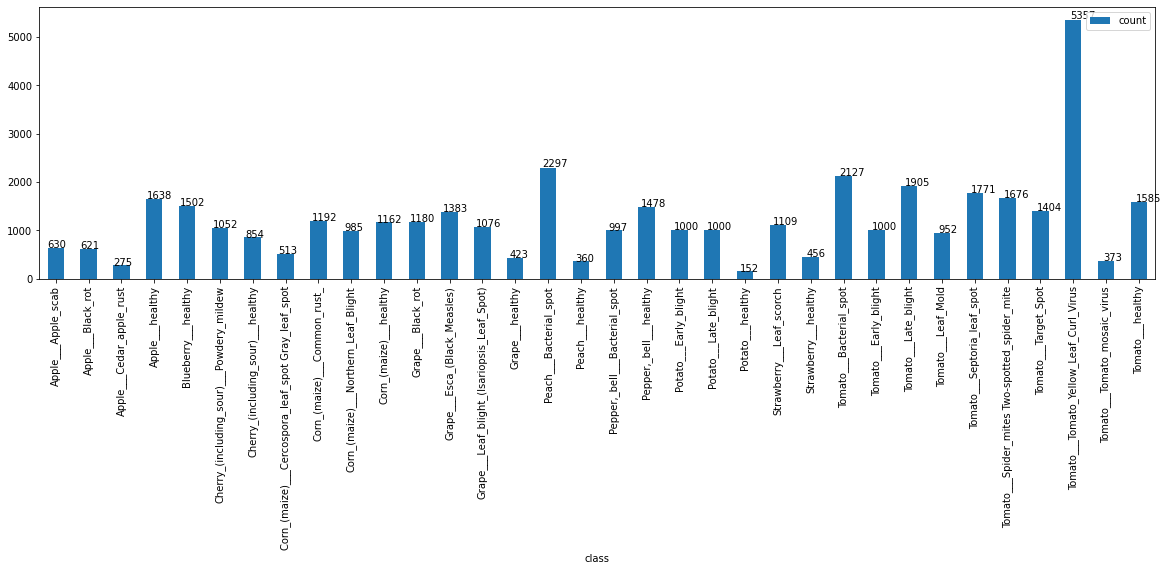

In [21]:
img_class = pandas.DataFrame(crop.img_dataset.class_to_idx, 
                             index=['class_id']).transpose().reset_index().rename(columns={'index':'class'})

img_count = pandas.DataFrame(dict(Counter(crop.img_dataset.targets)), 
                                    index=['count']).transpose().reset_index().rename(columns={'index':'class_id'})

ax = img_class.merge(img_count, on=['class_id'], how='inner').plot.bar(x='class', y='count', figsize=(20, 5))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

Things that we can try out to handle the imbalance in this dataset. Some options can be tried during the data pre-processing, while others can be tried during Training

#### Data Preparation
- Data Augmentation :- Increase the number of data points for the less frequent class
- Weighted Sampler :- To pick samples based on the number of data points

#### Training
- Re-weighted :- Loss function is influenced by assigning relatively higher costs to examples from minority classes
- Learning Rate Scheduling :- Warm-up LR, Step Decay LR, Cosine Decay LR, Hybrid, Annealing, Adaptive Decay LR
- Loss Function :- Use Focal Loss function
- Label Smoothening :- Instead of a 0 and 1 for the labels create a continuous distribution of the output 

#### Other Potential Options 
- Chipping Images :-
- With small datasets and too much overfitting, introducing background variation like backgrounds / shadows
- Merge near identical classes :- As the name suggests, merge smaller similar classes to create a larger dataset
- Re-sampling :- Over or under sampling

### Weighted Sampler

In [27]:
# perform undersampling to select 500 images per class. The lowest image count we have is 153 and the highest os 5000+. 
# majority of the classes though are near 500 mark.

# define a weighted sampler for the images 
lst_target = []
num_samples = len(crop.img_dataset)
label = list(crop.img_dataset.targets)
class_weights = [round(1.0/v,5) for k, v in dict(Counter(crop.img_dataset.targets)).items()]
weights = [class_weights[label[i]] for i in range(num_samples)]
sampler = WeightedRandomSampler(weights, num_samples, replacement=False)
img_loader = DataLoader(dataset=crop.img_dataset, batch_size=BATCH_SIZE, sampler=sampler)
sampler = WeightedRandomSampler(weights, num_samples, replacement=True)
img_loader = DataLoader(dataset=crop.img_dataset, batch_size=BATCH_SIZE, sampler=sampler)
for idx, (image, target) in enumerate(img_loader):
    lst_target.extend(list(target.numpy()))
    if idx%100 == 0 and idx > 0:
        print(f'Included data from first {idx * BATCH_SIZE} samples')
print(f'Included data from all {num_samples} samples')
print(f'Class distribution {dict(Counter(lst_target))}')

In [35]:
print(f'Class distribution {len(lst_target)}')

Class distribution 41485


### Balanced Random Selection (Dataset)

In [11]:
# the weighted sampler above will not work clearly since we would like to have a more balanced dataset here
# we need to create a Balanced Batch Sampler 
class BalancedBatchSampler(BatchSampler):
    def __init__(self, dataset, n_classes, n_samples, n_batches):
        loader = DataLoader(dataset)
        self.labels_list = []
        for _, label in loader:
            self.labels_list.append(label)
        self.labels = torch.LongTensor(self.labels_list)
        self.labels_set = list(set(self.labels.numpy()))
        self.label_to_indices = {label: numpy.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            numpy.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.dataset = dataset
        self.batch_size = n_batches
        self.dataset_size = self.n_samples * self.n_classes
        
        classes = numpy.random.choice(self.labels_set, self.n_classes, replace=False)
        self.indices = []
        for class_ in classes:
            self.indices.extend(self.label_to_indices[class_][
                           self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                     class_] + self.n_samples])
            self.used_label_indices_count[class_] += min(self.n_samples,len(self.label_to_indices[class_]))
            while self.used_label_indices_count[class_] < self.n_samples:
                numpy.random.shuffle(self.label_to_indices[class_])
                self.indices.extend(self.label_to_indices[class_][0:
                                            min(self.n_samples - self.used_label_indices_count[class_],
                                                len(self.label_to_indices[class_]))])
                self.used_label_indices_count[class_] += min(self.n_samples - self.used_label_indices_count[class_],
                                                len(self.label_to_indices[class_]))        
            
    def __iter__(self):
        while self.count  < self.dataset_size:
            yield from self.indices[self.count:self.count+self.batch_size]
            self.count += self.batch_size

    def __len__(self):
        return len(self.indices) // self.batch_size

In [12]:
n_classes = 34
n_samples = 500

balanced_batch_sampler = BalancedBatchSampler(crop.img_dataset, n_classes, n_samples, BATCH_SIZE)
lst_target = []
img_loader = DataLoader(dataset=crop.img_dataset, batch_size=BATCH_SIZE, sampler=balanced_batch_sampler)
for idx, (image, target) in enumerate(img_loader):
    # This is a dummy code, but you can write your implementation train the model here
    lst_target.extend(list(target.numpy()))
    if idx%100 == 0 and idx > 0:
        print(f'Included data from first {idx * BATCH_SIZE} samples')
print(f'Class distribution {dict(Counter(lst_target))}')

Included data from first 6400 samples
Included data from first 12800 samples
Class distribution {14: 500, 20: 500, 1: 500, 7: 500, 23: 500, 32: 500, 22: 500, 30: 500, 5: 500, 31: 500, 10: 500, 26: 500, 25: 500, 2: 500, 16: 500, 17: 500, 29: 500, 4: 500, 15: 500, 19: 500, 27: 500, 28: 500, 21: 500, 8: 500, 6: 500, 9: 500, 33: 500, 0: 500, 11: 500, 3: 500, 18: 500, 12: 500, 13: 500, 24: 500}


In [13]:
len(lst_target), len(set(lst_target))

(17000, 34)

### Balanced Random Selection (Folder)

In [16]:
n_samples = 500
if os.path.exists(BALANCED_DIR):
    shutil.rmtree(BALANCED_DIR)
shutil.copytree(PROCESSED_DIR, BALANCED_DIR, dirs_exist_ok=False)
# create a list of files to be moved
dirs = os.listdir(BALANCED_DIR)
if '.DS_Store' in dirs: dirs.remove('.DS_Store')

dict_files = {}
for d, files in [(d, os.listdir(BALANCED_DIR + d)) for d in dirs if d != '.DS_Store']:
    if '.DS_Store' in files: files.remove('.DS_Store')
    dict_files[d] = numpy.random.choice(files, size=n_samples, replace=False) if len(files) > n_samples else files

for key, val in dict_files.items():
    del_files = []
    all_files = os.listdir(BALANCED_DIR + key)
    if len(all_files) > n_samples:
        del_files = list(set(all_files) - set(val))
    for f in del_files:
        os.remove(os.path.join(BALANCED_DIR, key, f))

In [17]:
for key, val in dict_files.items():
    print(key ,len(val))

Strawberry___healthy 500
Grape___Black_rot 500
Potato___Early_blight 500
Blueberry___healthy 500
Corn_(maize)___healthy 500
Tomato___Target_Spot 500
Peach___healthy 500
Potato___Late_blight 500
Tomato___Late_blight 500
Tomato___Tomato_mosaic_virus 500
Pepper,_bell___healthy 500
Tomato___Leaf_Mold 500
Grape___Leaf_blight_(Isariopsis_Leaf_Spot) 500
Cherry_(including_sour)___Powdery_mildew 500
Apple___Cedar_apple_rust 500
Tomato___Bacterial_spot 500
Grape___healthy 500
Tomato___Early_blight 500
Corn_(maize)___Common_rust_ 500
Grape___Esca_(Black_Measles) 500
Tomato___healthy 500
Cherry_(including_sour)___healthy 500
Tomato___Tomato_Yellow_Leaf_Curl_Virus 500
Apple___Apple_scab 500
Corn_(maize)___Northern_Leaf_Blight 500
Tomato___Spider_mites Two-spotted_spider_mite 500
Peach___Bacterial_spot 500
Pepper,_bell___Bacterial_spot 500
Tomato___Septoria_leaf_spot 500
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot 500
Apple___Black_rot 500
Apple___healthy 500
Strawberry___Leaf_scorch 500
Pota

### Augmentation
Augmentation can be done in multiple ways like 
- Images can be rotated 
- Images can be zoomed in/out
- Adding some amount of noise to the images
- Images have been flipped
- Images have low brightness
- Images have been sheared

### Train | Test | Validate Split

In [183]:
# Current data in the train folder. We need move some of these images for test and validation purpose
test_sample = int(n_samples * .2)
validate_sample = int(n_samples * .1)

if os.path.exists(str(Path(INPUT_DIR).parent.absolute())):
    shutil.rmtree(str(Path(INPUT_DIR).parent.absolute()))
shutil.copytree(BALANCED_DIR, INPUT_DIR, dirs_exist_ok=False)


dirs = os.listdir(INPUT_DIR)
if ('.DS_Store' in dirs): dirs.remove('.DS_Store')
print(f'Processing total {len(dirs)} labels in the data - ')


os.mkdir(str(Path(INPUT_DIR).parent.absolute()) + '/test/')
os.mkdir(str(Path(INPUT_DIR).parent.absolute()) + '/validate/')
for d in dirs:
    files = os.listdir(INPUT_DIR + d)
    if ('.DS_Store' in files): files.remove('.DS_Store')

    list_test = list(numpy.random.choice(files, size=test_sample+validate_sample, replace=False))
    list_valid = list(numpy.random.choice(list_test, size=validate_sample, replace=False))
    
    source = INPUT_DIR + d
    test = str(Path(INPUT_DIR).parent.absolute()) + '/test/' + d
    os.mkdir(test)
    for file in list_test:
        os.rename(source + '/' + file, test + '/' + file)
    
    valid = str(Path(INPUT_DIR).parent.absolute()) + '/validate/' + d
    os.mkdir(valid)
    for file in list_valid:
        os.rename(test + '/' + file, valid + '/' + file)

Processing total 34 labels in the data - 


### Experiment With Augmentation 

In [67]:
ia.seed(241)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order

(1, 256, 256, 3)
(2, 256, 256, 3)


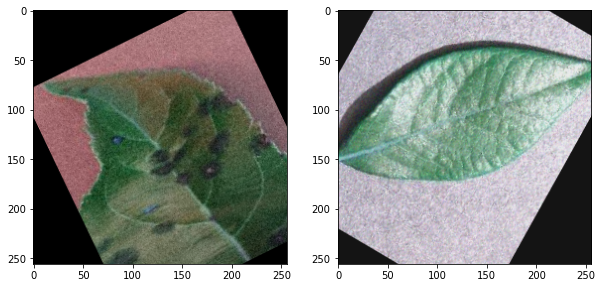

In [68]:
# read an image
import cv2 
x = cv2.imread('./images/balanced/Apple___Apple_scab/01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003.JPG')
y = cv2.imread('./images/balanced/Blueberry___healthy/00fee259-67b7-4dd7-8b36-12503bbdba14___RS_HL 2681.JPG')
x = x[numpy.newaxis,:,:,:]
y = y[numpy.newaxis,:,:,:]
z = numpy.concatenate((x, y), axis=0)
print(x.shape)
print(z.shape)

# apply augmentation
z = seq(images = z)
#print(y)

fig, axes = plt.subplots(figsize = (10,10), ncols=2, nrows=1 )
# observe results 
axes[0].imshow(z[0])
axes[1].imshow(z[1])